# Imports

In [1]:
!pip install transformers --quiet
!pip install gensim==3.8.3
!pip install -q sentencepiece
!pip install tensorflow_datasets
!pip install -q tf-models-official

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from pprint import pprint

import os
import nltk
from nltk.data import find
import pandas as pd

import matplotlib.pyplot as plt

import ast
import re

from transformers import BertTokenizer, TFBertModel, AutoTokenizer, AutoModel, TFAutoModel
import textwrap

from transformers import T5Tokenizer, TFT5Model, TFT5ForConditionalGeneration
from transformers import GPT2Tokenizer
# import tensorflow_datasets as tfds

In [2]:
data_path = "nbme-score-clinical-patient-notes/"
print("Project Path:", data_path)

Project Path: nbme-score-clinical-patient-notes/


In [3]:
os.listdir(data_path)

['test.csv',
 'patient_notes.csv',
 'train.csv',
 'features.csv',
 'sample_submission.csv']

In [4]:
features = pd.read_csv(data_path + 'features.csv')
patient_notes = pd.read_csv(data_path + 'patient_notes.csv')
sample_submission = pd.read_csv(data_path + 'sample_submission.csv')
training_data = pd.read_csv(data_path + 'train.csv')
test_data = pd.read_csv(data_path + 'train.csv')

In [5]:
training_data.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


In [6]:
features.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [7]:
text_notes = patient_notes["pn_history"]
patient_notes.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [8]:
patient_notes_w_training = pd.merge(training_data, patient_notes, how="left", on=["pn_num", "case_num"])
# patient_notes_w_training = patient_notes_w_training[patient_notes_w_training.annotation.apply(lambda w: len(w)) > 2]
patient_notes_w_training = pd.merge(patient_notes_w_training, features, how="inner", on=["feature_num", "case_num"])
# patient_notes_w_training = patient_notes_w_training.drop(["case_num_y"], axis=1)
patient_notes_w_training.head(10)

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...
2,00046_000,0,46,0,['father: heart attack'],['824 844'],Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...
3,00082_000,0,82,0,['Father MI'],['622 631'],17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...
4,00100_000,0,100,0,['Dad-MI'],['735 741'],HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...
5,00161_000,0,161,0,['father had acute MI'],['601 620'],"17 y/o M , Dillon Cleveland comes with c/o of ...",Family-history-of-MI-OR-Family-history-of-myoc...
6,00188_000,0,188,0,['father heart attach'],['716 735'],17 yo M college student comes to the clinic du...,Family-history-of-MI-OR-Family-history-of-myoc...
7,00211_000,0,211,0,['Father MI'],['682 688;695 697'],HPI: Patient is a 17 yo m with a c/o of palpit...,Family-history-of-MI-OR-Family-history-of-myoc...
8,00224_000,0,224,0,['dad had recent MI'],['483 500'],"Pt is a 17 y/o M w/ episodic feeling of ""heart...",Family-history-of-MI-OR-Family-history-of-myoc...
9,00225_000,0,225,0,['dad had heart attack'],['735 755'],17 y/o previously healthy male here with heart...,Family-history-of-MI-OR-Family-history-of-myoc...


In [9]:
### Unique features to classify
len(patient_notes_w_training['feature_text'].unique())

131

In [10]:
len(patient_notes_w_training['pn_num'].unique())

1000

In [11]:
patient_notes_w_training.iloc[7]['pn_history'][695:697]

'MI'

In [12]:
numbers = [int(i) for i in (eval(patient_notes_w_training['location'][5])[0]).split(" ")]
numbers

[601, 620]

In [13]:
import ast

In [14]:
### Filter out the integers in the location feature
double_check = [ast.literal_eval(i) for i in patient_notes_w_training['location']]
# double_check = [i.split(";") for i in double_check]
new_locations = []
for i in double_check:
    if len(i) > 0:
        new_locations.append(i[0].split(";"))
    else:
        new_locations.append(i)
new_locations
numbers_location = []
for i in new_locations:
    if len(i) > 0:
        numbers_location.append([j.split(" ") for j in i])
    else:
        numbers_location.append(i)
numbers_location
cleaned_up = []
for i in numbers_location:
    if len(i) > 0:
        multi_list = []
        for j in i:
            if len(i) > 1:
                double_list = [int(e) for e in j]
                multi_list.append(double_list)
            else:
                multi_list = [int(e) for e in j]
        cleaned_up.append(multi_list)
    else:
        cleaned_up.append(i)
cleaned_up

[[696, 724],
 [],
 [824, 844],
 [622, 631],
 [735, 741],
 [601, 620],
 [716, 735],
 [[682, 688], [695, 697]],
 [483, 500],
 [735, 755],
 [[452, 458], [463, 476]],
 [323, 339],
 [621, 637],
 [905, 938],
 [552, 558],
 [591, 607],
 [483, 493],
 [[304, 310], [332, 340]],
 [666, 691],
 [],
 [855, 868],
 [659, 673],
 [[876, 882], [888, 890]],
 [490, 513],
 [603, 623],
 [917, 949],
 [765, 783],
 [649, 662],
 [[621, 627], [632, 644]],
 [758, 774],
 [568, 590],
 [470, 493],
 [672, 691],
 [[511, 517], [522, 524]],
 [698, 716],
 [708, 724],
 [[567, 570], [575, 577]],
 [564, 589],
 [[689, 695], [716, 722]],
 [],
 [[556, 562], [567, 569]],
 [[708, 711], [720, 722]],
 [],
 [],
 [929, 939],
 [568, 577],
 [732, 748],
 [677, 686],
 [],
 [592, 602],
 [849, 879],
 [492, 514],
 [],
 [],
 [894, 907],
 [379, 385],
 [808, 826],
 [372, 409],
 [641, 663],
 [[681, 684], [689, 691]],
 [575, 603],
 [693, 702],
 [],
 [465, 475],
 [677, 688],
 [599, 613],
 [814, 836],
 [883, 900],
 [715, 737],
 [485, 501],
 [651, 6

In [15]:
patient_notes_w_training['location'] = cleaned_up
# patient_notes_w_training.head()

In [16]:
### Create a separate label feature to identify when annotations are in the pn_history and help with classification
label_array = []
for i in range(len(patient_notes_w_training)):
    if len(patient_notes_w_training.iloc[i]['annotation']) > 2:
        label_array.append(1)
    else:
        label_array.append(0)
patient_notes_w_training["label"] = label_array
patient_notes_w_training.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,label
0,00016_000,0,16,0,['dad with recent heart attcak'],"[696, 724]",HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...,1
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...,0
2,00046_000,0,46,0,['father: heart attack'],"[824, 844]",Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...,1
3,00082_000,0,82,0,['Father MI'],"[622, 631]",17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...,1
4,00100_000,0,100,0,['Dad-MI'],"[735, 741]",HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...,1


In [17]:
#import tensorflow_datasets as tfds
import tensorflow_hub as hub
#import tensorflow_models as tfm

In [18]:
bio_folder_bert = "biobert_v1.1_pubmed/"
tf.io.gfile.listdir(bio_folder_bert)

['model.ckpt-1000000.meta',
 'config.json',
 'model.ckpt-1000000.index',
 'vocab.txt',
 'pytorch_model.bin',
 '.ipynb_checkpoints',
 'model.ckpt-1000000.data-00000-of-00001']

In [19]:
train_data = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(text_notes, tf.string),
    tf.cast(patient_notes["case_num"], tf.int32
            ))
))

In [20]:
display_data = next(iter(train_data.batch(100)))

In [21]:
display_data[:5]

(<tf.Tensor: shape=(100,), dtype=string, numpy=
 array([b"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like his heart is jumping out of his chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had MI recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std",
        b'17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness, pressure in the chest

### Initialize BioBert Model

In [22]:
import json

### Tokenizer

In [23]:
bio_bert_tokenizer = BertTokenizer.from_pretrained(bio_folder_bert, local_files_only=True)
bio_bert_tokenizer_gh = AutoTokenizer.from_pretrained("gsarti/biobert-nli", from_pt=True)

In [24]:
bio_bert_tokenizer_gh.tokenize(patient_notes_w_training["pn_history"][0])

['HP',
 '##I',
 ':',
 '17',
 '##yo',
 'M',
 'presents',
 'with',
 'p',
 '##al',
 '##pit',
 '##ations',
 '.',
 'Pat',
 '##ient',
 'reports',
 '3',
 '-',
 '4',
 'months',
 'of',
 'intermittent',
 'episodes',
 'of',
 '"',
 'heart',
 'beating',
 '/',
 'pounding',
 'out',
 'of',
 'my',
 'chest',
 '.',
 '"',
 '2',
 'days',
 'ago',
 'during',
 'a',
 'soccer',
 'game',
 'had',
 'an',
 'episode',
 ',',
 'but',
 'this',
 'time',
 'had',
 'chest',
 'pressure',
 'and',
 'felt',
 'as',
 'if',
 'he',
 'were',
 'going',
 'to',
 'pass',
 'out',
 '(',
 'did',
 'not',
 'lose',
 'con',
 '##cious',
 '##ness',
 ')',
 '.',
 'Of',
 'note',
 'patient',
 'end',
 '##orse',
 '##s',
 'a',
 '##bus',
 '##ing',
 'add',
 '##eral',
 '##l',
 ',',
 'primarily',
 'to',
 'study',
 '(',
 '1',
 '-',
 '3',
 'times',
 'per',
 'week',
 ')',
 '.',
 'Before',
 'recent',
 'soccer',
 'game',
 ',',
 'took',
 'add',
 '##er',
 '##ral',
 '##l',
 'night',
 'before',
 'and',
 'morning',
 'of',
 'game',
 '.',
 'Den',
 '##ies',
 'short',


In [25]:
test_input = bio_bert_tokenizer_gh([patient_notes_w_training["pn_history"][0], patient_notes_w_training["pn_history"][1]], 
              max_length=10,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
test_input

{'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[  101, 18444,  2240,   131,  1542,  7490,   150,  8218,  1114,
          102],
       [  101,  1542,   162,   120,   152,   150,  8784, 14424, 16972,
          102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

### Model

In [26]:
import sklearn
# !pip install torch torchvision

In [27]:
config_path = os.path.join(bio_folder_bert, "bert_config.json")
config_path

'biobert_v1.1_pubmed/bert_config.json'

In [28]:
bio_bert_model = TFBertModel.from_pretrained(bio_folder_bert, local_files_only=True, from_pt=True)
bio_bert_model_gc = AutoModel.from_pretrained("gsarti/biobert-nli")

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
bio_bert_model_gc

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [30]:
bio_bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [31]:
len(bio_bert_model.weights)

199

In [32]:
bio_bert_model.weights[0]

<tf.Variable 'tf_bert_model/bert/embeddings/word_embeddings/weight:0' shape=(28996, 768) dtype=float32, numpy=
array([[-0.02646292, -0.00737567, -0.02888124, ..., -0.036186  ,
        -0.03402966,  0.01820285],
       [-0.01152121,  0.01323619, -0.05758354, ..., -0.02354121,
        -0.06789913, -0.00655153],
       [ 0.02323636,  0.00516385, -0.02507166, ..., -0.06960029,
        -0.02208178, -0.02544149],
       ...,
       [-0.02961127, -0.05189098, -0.05919506, ..., -0.05500455,
        -0.05904943,  0.01434717],
       [-0.04530165,  0.01503256, -0.06112099, ..., -0.0789494 ,
        -0.02989064, -0.00505865],
       [ 0.03025113, -0.00555819, -0.04065674, ..., -0.02147963,
        -0.05192445, -0.0016351 ]], dtype=float32)>

### Train & Test Data Set

In [33]:
# filtered_training_data = training_data[training_data.annotation.apply(lambda w: len(w)) > 2]
filtered_training_data = patient_notes_w_training
filtered_training_data.head()

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text,label
0,00016_000,0,16,0,['dad with recent heart attcak'],"[696, 724]",HPI: 17yo M presents with palpitations. Patien...,Family-history-of-MI-OR-Family-history-of-myoc...,1
1,00041_000,0,41,0,[],[],17 Y/O M CAME TO THE CLINIC C/O HEART POUNDING...,Family-history-of-MI-OR-Family-history-of-myoc...,0
2,00046_000,0,46,0,['father: heart attack'],"[824, 844]",Mr. Cleveland is a 17yo M who was consented by...,Family-history-of-MI-OR-Family-history-of-myoc...,1
3,00082_000,0,82,0,['Father MI'],"[622, 631]",17 yo M w/ no cardiac or arrhythmia PMH presen...,Family-history-of-MI-OR-Family-history-of-myoc...,1
4,00100_000,0,100,0,['Dad-MI'],"[735, 741]",HPI: Dillon Cleveland is an otherwise healthy ...,Family-history-of-MI-OR-Family-history-of-myoc...,1


In [34]:
len(patient_notes_w_training["feature_text"].unique())

131

### Feature & Similarity Scores

In [35]:
from scipy.spatial.distance import dice, cosine, jaccard

In [36]:
patient_notes_w_training.iloc[0]["feature_text"]
len(bio_bert_tokenizer_gh(patient_notes_w_training.iloc[0]["pn_history"], truncation=True, padding=True, max_length=200).input_ids)

200

In [37]:
dice(bio_bert_tokenizer_gh(patient_notes_w_training.iloc[2]["pn_history"], truncation=True, padding='max_length', max_length=200).input_ids, 
     bio_bert_tokenizer_gh(patient_notes_w_training.iloc[2]["annotation"], truncation=True, padding='max_length', max_length=200).input_ids)



-32.658736157341885

In [38]:
patient_notes_w_training['feature_text'][0]

'Family-history-of-MI-OR-Family-history-of-myocardial-infarction'

In [39]:
x_train_set, y_train_set, x_valid_set, y_valid_set = sk.model_selection.train_test_split(patient_notes_w_training['pn_history'], patient_notes_w_training['label'], test_size=0.25, random_state=44)
x_train_set.index = np.arange(len(x_train_set))                                                                                                                                                                                  
y_train_set.index = np.arange(len(y_train_set))
x_train_set

0        20 y/o F c/o abdominal pain  \r\n5/10. from la...
1        CC: 35 y/o male patient that comes to clinic d...
2        Ms. Madden is a 20y/o F who presents with head...
3        Edie Whelan is a 26yo F who presents with hist...
4        Patient is a 44 year old G2P2 female with irre...
                               ...                        
10720    This is a 17 year old male presenting with pal...
10721    Kane smith, 17 yo old male presented with ches...
10722    67 y/o F c/o insomnia for the past 3 weeks. He...
10723    Ms. Montgomery is 44year old female with cheif...
10724    CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
Name: pn_history, Length: 10725, dtype: object

In [40]:
x_feature_set, y_feature_set, x_feature_valid_set, y_feature_valid_set = sk.model_selection.train_test_split(patient_notes_w_training['pn_history'], patient_notes_w_training['feature_text'], test_size=0.25, random_state=44)
x_feature_set.index = np.arange(len(x_feature_set))                                                                                                                                                                                  
y_feature_set.index = np.arange(len(y_feature_set))
x_feature_set

0        20 y/o F c/o abdominal pain  \r\n5/10. from la...
1        CC: 35 y/o male patient that comes to clinic d...
2        Ms. Madden is a 20y/o F who presents with head...
3        Edie Whelan is a 26yo F who presents with hist...
4        Patient is a 44 year old G2P2 female with irre...
                               ...                        
10720    This is a 17 year old male presenting with pal...
10721    Kane smith, 17 yo old male presented with ches...
10722    67 y/o F c/o insomnia for the past 3 weeks. He...
10723    Ms. Montgomery is 44year old female with cheif...
10724    CC: Headache\r\nHPI: Ms Maddon is a 20 year ol...
Name: pn_history, Length: 10725, dtype: object

In [41]:
x_valid_set.index = np.arange(len(x_valid_set))
y_valid_set.index = np.arange(len(y_valid_set))
x_valid_set

0        1
1        1
2        1
3        1
4        1
        ..
10720    0
10721    1
10722    1
10723    1
10724    1
Name: label, Length: 10725, dtype: int64

In [42]:
x_feature_valid_set.index = np.arange(len(x_feature_valid_set))
y_feature_valid_set.index = np.arange(len(y_feature_valid_set))
x_feature_valid_set

0                                      Not-sexually-active
1        NSAID-use-OR-Nonsteroidal-anti-inflammatory-dr...
2                                                 Myalgias
3                                      No-illicit-drug-use
4                                         Irregular-menses
                               ...                        
10720    No-hair-changes-OR-no-nail-changes-OR-no-tempe...
10721                                           Chest-pain
10722                                 Son-died-3-weeks-ago
10723                                               Female
10724                            No-known-illness-contacts
Name: feature_text, Length: 10725, dtype: object

In [43]:
x_train_data_set = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(x_train_set, tf.string),
    tf.cast(x_valid_set, tf.int32
            ))
))

In [44]:
x_feature_data_set = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(x_feature_set, tf.string),
    tf.cast(x_feature_valid_set, tf.string))
))

In [45]:
valid_data_set = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(y_train_set, tf.string),
    tf.cast(y_valid_set, tf.int32
            ))
))

In [46]:
feature_valid_data_set = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(y_feature_set, tf.string),
    tf.cast(y_feature_valid_set, tf.string
            ))
))

In [47]:
x_train_data_set_2 = (tf.data.Dataset.from_tensor_slices(
    (
    tf.cast(filtered_training_data['annotation'], tf.string),
    tf.cast(filtered_training_data['case_num'], tf.int32
            ))
))

In [48]:
x_feature_data_set, x_feature_labels = next(iter(x_feature_data_set.batch(len(x_feature_data_set))))
y_feature_data_set, y_feature_labels = next(iter(feature_valid_data_set.batch(len(feature_valid_data_set))))

In [49]:
x_train_data_set, x_train_labels = next(iter(x_train_data_set.batch(len(x_train_data_set))))
x_valid_data_set, x_valid_labels = next(iter(valid_data_set.batch(len(valid_data_set))))

In [50]:
x_train_data_set_2, x_train_labels_2 = next(iter(x_train_data_set_2.batch(5000)))

In [51]:
x_train_data_set[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'20 y/o F c/o abdominal pain  \r\n5/10. from last 10 hours.\r\ndull and ache.,cramping pain in the right lower quadrant.\r\nno radiation.\r\nwalking makes it worse.took ibuprofen but not much help.\r\nno fever chills,no discharge,no dysuria,no blood in the urine.\r\npat h/o of similar episodes 3-4 in the last 6 months..not allergic .no medicines other than ibuprofen..no hospitalisation trauma or surgeries .no past illness.\r\nfamily h/o not significant..\r\nlmp 2 weeks ago.regular 28 days lasts for 4 days.moderare flow.age of menarche 13.\r\nlast sexual encounter 9 months ago with boy friend always uses condoms.',
       b'CC: 35 y/o male patient that comes to clinic due to stomach pain.\r\nHPI: Patient mentions pain began 2 months ago. The pain was described as a 5/10 gnawing, and burning in the epigastric area. It does not radiate or move anywhere else. Mentions having nausea , pain waking him from sleep, bloating, and dark stools 

In [52]:
x_train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 1], dtype=int32)>

In [53]:
x_train_data_set_2[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"['dad with recent heart attcak']", b'[]',
       b"['father: heart attack']", b"['Father MI']"], dtype=object)>

In [54]:
len(x_valid_data_set)

3575

### Model Parameters

In [55]:
bio_bert_input = bio_bert_tokenizer_gh(x_train_set[0], 
              max_length=10,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

In [56]:
bio_bert_output = bio_bert_model(bio_bert_input)
bio_bert_output

(<tf.Tensor: shape=(1, 10, 768), dtype=float32, numpy=
 array([[[ 0.27284366,  0.44795707,  0.10222741, ...,  0.19019942,
           0.50943273, -0.40686905],
         [-0.21845624,  0.68632376, -0.06660731, ...,  0.16574076,
          -0.02029915, -0.5228264 ],
         [ 0.6664245 ,  0.6345389 , -0.09287635, ...,  0.11792423,
           0.65452594, -0.955945  ],
         ...,
         [ 0.16055766,  1.0457727 ,  0.06934888, ...,  0.11574717,
           0.6909187 , -0.56277466],
         [ 0.12902772,  0.8637038 ,  0.11093444, ...,  0.24506088,
           0.37744752, -0.33942655],
         [ 0.2728439 ,  0.4479569 ,  0.10222763, ...,  0.19019958,
           0.5094327 , -0.4068691 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[-0.07626752,  0.36129317,  0.76790726, -0.998019  ,  0.9757103 ,
          0.18313386,  0.05530562,  0.8327823 , -0.07079367,  0.26752484,
          0.4620882 ,  0.9648853 ,  0.9119119 , -0.8520235 , -0.15731724,
          0.145

In [57]:
MAX_SEQUENCE_LENGTH = 100
bio_bert_tokenizer_gh.encode_plus(x_train_set[0], max_length=200, padding='max_length', truncation=True, return_tensors='tf', 
                                 return_token_type_ids=True, return_attention_mask=True)



{'input_ids': <tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[  101,  1406,   194,   120,   184,   143,   172,   120,   184,
        24716,  2489,   126,   120,  1275,   119,  1121,  1314,  1275,
         2005,   119, 10884,  1105, 12953,   119,   117,   172,  4515,
         2624,  2489,  1107,  1103,  1268,  2211,   186, 18413,  6922,
          119,  1185,  8432,   119,  3179,  2228,  1122,  4146,   119,
         1261,   178,  7925,  1643,  2180, 13488,  1133,  1136,  1277,
         1494,   119,  1185, 10880, 11824,  1116,   117,  1185, 12398,
          117,  1185,   173,  6834, 19700,   117,  1185,  1892,  1107,
         1103, 19968,   119, 26227,   177,   120,   184,  1104,  1861,
         3426,   124,   118,   125,  1107,  1103,  1314,   127,  1808,
          119,   119,  1136,  1155, 26949,   119,  1185, 26016,  1168,
         1190,   178,  7925,  1643,  2180, 13488,   119,   119,  1185,
         2704,  5771, 14780,  1137, 12814,  3377,   119,  1185,  1763,
         6946, 

In [73]:
### Tokenize patient history and feature text at the same time
num_train_examples = len(x_feature_data_set)
num_test_examples = len(y_feature_data_set)

MAX_SEQUENCE_LENGTH = 300
train_features_examples = [x.decode('utf-8') for x in x_feature_data_set.numpy()]
# train_examples = [x.decode('utf-8') for x in x_feature_data_set.numpy()]
valid_features_examples = [x.decode('utf-8') for x in y_feature_data_set.numpy()]

x_train_feature = bio_bert_tokenizer_gh( train_features_examples[:num_train_examples],
                             max_length = MAX_SEQUENCE_LENGTH,
                             truncation=True,
                             padding='max_length',
                             return_tensors='tf'
                            )

valid_feature_examples = bio_bert_tokenizer_gh(valid_features_examples[:num_train_examples],
                                max_length = MAX_SEQUENCE_LENGTH,
                                truncation = True,
                                padding='max_length',
                                return_tensors='tf')

train_feature_label = x_feature_labels[:num_train_examples]
valid_feature_labels = y_feature_labels[:num_train_examples]

In [74]:
num_train_examples = len(x_train_data_set)
num_test_examples = len(x_valid_data_set)

MAX_SEQUENCE_LENGTH = 300
train_examples = [x.decode('utf-8') for x in x_train_data_set.numpy()]
valid_examples = [x.decode('utf-8') for x in x_valid_data_set.numpy()]

x_train = bio_bert_tokenizer_gh(train_examples[:num_train_examples],
                             max_length = MAX_SEQUENCE_LENGTH,
                             truncation=True,
                             padding='max_length',
                             return_tensors='tf'
                            )

valid_train = bio_bert_tokenizer_gh(valid_examples[:num_train_examples],
                                max_length = MAX_SEQUENCE_LENGTH,
                                truncation = True,
                                padding='max_length',
                                return_tensors='tf')

train_label = x_train_labels[:num_train_examples]
valid_train_labels = x_valid_labels[:num_train_examples]

In [75]:
x_train.token_type_ids.shape

TensorShape([10725, 300])

In [76]:
### Create a label function that will compare the annotations and patient notes using dice and cosine similarities to start
### Then try implementing the Coreference resolution
bio_bert_model_gc(x_train.input_ids, x_train.token_type_ids, x_train.attention_mask)


AttributeError: EagerTensor object has no attribute 'size'. 
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
      

In [63]:
import tensorflow_addons as tfa

/Users/nicholasbrathwaite/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [77]:
def create_bert_classifier_model(bert_model, 
                              num_training_layers = 0, 
                              dimension_size = 200, 
                              dropout=0.1, 
                              learning_rate = 0.001):
    
#     bert_model.trainable = True
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_id_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')
    
    bio_bert_input = {'input_ids': input_ids,
                     'token_type_ids': token_type_ids,
                     'attention_mask': attention_mask}
    
    bio_bert_output = bert_model(bio_bert_input)
    
    pooler_token = bio_bert_output[1]
    
    hidden_layer = tf.keras.layers.Dense(dimension_size, activation= "ReLU", name = 'hidden_layer')(pooler_token)
    
    hidden_layer = tf.keras.layers.Dense(100, activation="relu")(hidden_layer)
    
    hidden_layer = tf.keras.layers.Dropout(dropout)(hidden_layer)
    
    classification = tf.keras.layers.Dense(1, activation = "sigmoid", name='classification_layer')(hidden_layer)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                 loss = "binary_crossentropy",
                                                 metrics = ['Accuracy', tf.keras.metrics.Precision(),
                                                           tf.keras.metrics.Recall()])
    return classification_model
    

In [80]:
baseline_bio_bert_model = create_bert_classifier_model(bio_bert_model)

In [78]:
baseline_bio_bert_model_2 = create_bert_classifier_model(bio_bert_model)

In [81]:
baseline_bio_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 200)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 200)]        0           []                               
                                                                                                  
 token_type_id_layer (InputLaye  [(None, 200)]       0           []                               
 r)                                                                                               
                                                                                              

In [79]:
baseline_bio_bert_model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 300)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 300)]        0           []                               
                                                                                                  
 token_type_id_layer (InputLaye  [(None, 300)]       0           []                               
 r)                                                                                               
                                                                                            

In [80]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta = 0.00001,
    patience = 2,
    verbose = 1,
    mode='auto',
    restore_best_weights=True
)

In [83]:
bio_bert_model_history = baseline_bio_bert_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], train_label, 
                            validation_data = ([valid_train.input_ids, valid_train.token_type_ids, valid_train.attention_mask], valid_train_labels),
                            batch_size=50, epochs=2, callbacks=[early_stop])


Epoch 1/2
215/215 [==============================] - 5498s 25s/step - loss: 0.7510 - Accuracy: 0.6809 - precision: 0.6925 - recall: 0.9707 - val_loss: 0.6320 - val_Accuracy: 0.6903 - val_precision: 0.6903 - val_recall: 1.0000
Epoch 2/2
215/215 [==============================] - 5321s 25s/step - loss: 0.6231 - Accuracy: 0.6931 - precision: 0.6931 - recall: 1.0000 - val_loss: 0.6192 - val_Accuracy: 0.6903 - val_precision: 0.6903 - val_recall: 1.0000


In [81]:
bio_bert_model_history_2 = baseline_bio_bert_model_2.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], train_label, 
                            validation_data = ([valid_train.input_ids, valid_train.token_type_ids, valid_train.attention_mask], valid_train_labels),
                            batch_size=32, epochs=2, callbacks=[early_stop])

Epoch 1/2
336/336 [==============================] - 10223s 30s/step - loss: 0.6519 - Accuracy: 0.6779 - precision_1: 0.6925 - recall_1: 0.9626 - val_loss: 0.6192 - val_Accuracy: 0.6903 - val_precision_1: 0.6903 - val_recall_1: 1.0000
Epoch 2/2
336/336 [==============================] - 9836s 29s/step - loss: 0.6209 - Accuracy: 0.6931 - precision_1: 0.6931 - recall_1: 1.0000 - val_loss: 0.6220 - val_Accuracy: 0.6903 - val_precision_1: 0.6903 - val_recall_1: 1.0000


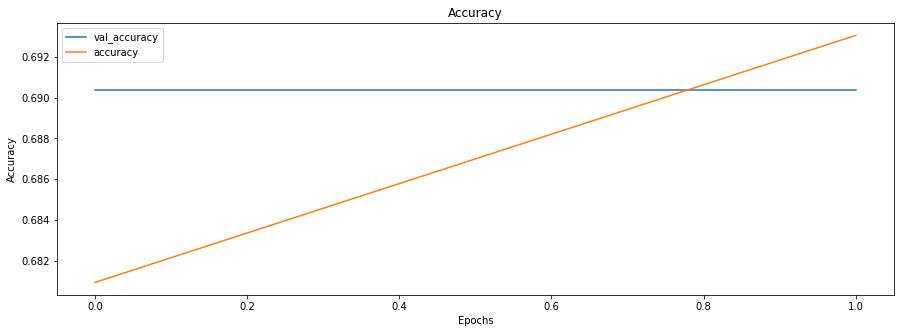

In [84]:
plt.figure(figsize=(15,5))
plt.plot(range(bio_bert_model_history.epoch[-1]+1), bio_bert_model_history.history["val_Accuracy"], label="val_accuracy")
plt.plot(range(bio_bert_model_history.epoch[-1]+1), bio_bert_model_history.history["Accuracy"], label="accuracy")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show();

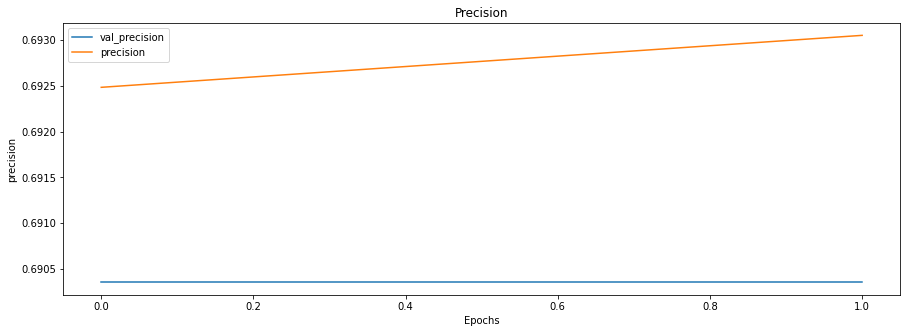

In [86]:
plt.figure(figsize=(15,5))
plt.plot(range(bio_bert_model_history.epoch[-1]+1), bio_bert_model_history.history["val_precision"], label="val_precision")
plt.plot(range(bio_bert_model_history.epoch[-1]+1), bio_bert_model_history.history["precision"], label="precision")
plt.title("Precision")
plt.ylabel("precision")
plt.xlabel("Epochs")
plt.legend()
plt.show();

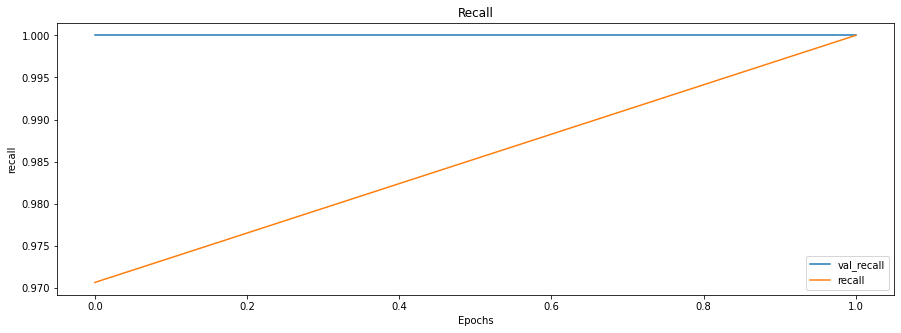

In [87]:
plt.figure(figsize=(15,5))
plt.plot(range(bio_bert_model_history.epoch[-1]+1), bio_bert_model_history.history["val_recall"], label="val_recall")
plt.plot(range(bio_bert_model_history.epoch[-1]+1), bio_bert_model_history.history["recall"], label="recall")
plt.title("Recall")
plt.ylabel("recall")
plt.xlabel("Epochs")
plt.legend()
plt.show();

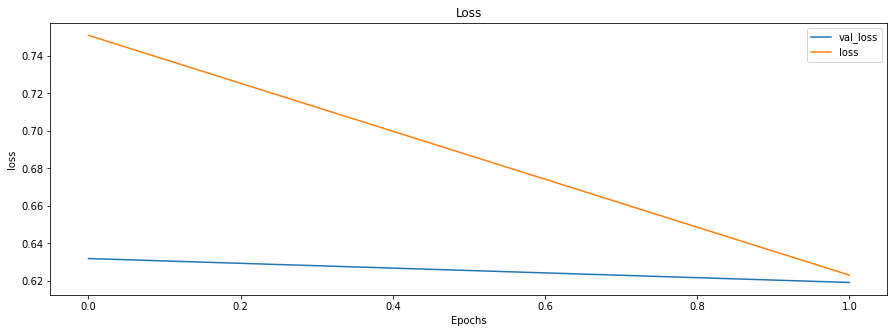

In [88]:
plt.figure(figsize=(15,5))
plt.plot(range(bio_bert_model_history.epoch[-1]+1), bio_bert_model_history.history["val_loss"], label="val_loss")
plt.plot(range(bio_bert_model_history.epoch[-1]+1), bio_bert_model_history.history["loss"], label="loss")
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show();